1. Loading the data

In [77]:
import struct
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
from scipy.io import loadmat

mnist = loadmat("input/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

print(mnist_label.shape)

(70000,)


Then, let's try plotting the image

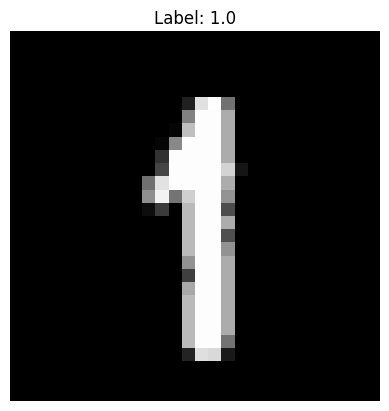

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  33 225 255 113   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 129 253 253 172   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   5 191 253 253 172   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   5 136 253 253 253 172   0   0   0   0   0   

In [79]:
import matplotlib.pyplot as plt

# Reshape the first row into a 28x28 image
first_image = mnist_data[11000].reshape(28, 28)

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {mnist_label[11000]}")
plt.axis('off')
plt.show()

print(mnist_data[11000])

Stratified Sampling:

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(
    mnist_data, mnist_label,
    test_size = 10000/70000,
    stratify = mnist_label,
    random_state = 42 
)

print("Label distribution in training set:", np.bincount(Y_train.astype(int)))
print("Label distribution in testing set:", np.bincount(Y_test.astype(int)))

Label distribution in training set: [5917 6752 5991 6121 5849 5411 5894 6251 5850 5964]
Label distribution in testing set: [ 986 1125  999 1020  975  902  982 1042  975  994]


That's too much for an SVM, let's reduce the size:

In [119]:

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = X_train_pca/255.0
X_test_pca = X_test_pca/255.0

In [120]:


svc = svm.SVC(C = 5, gamma = 0.05).fit(X_train_pca, Y_train)



In [121]:
predictions = svc.predict(X_test_pca)
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 98.78%


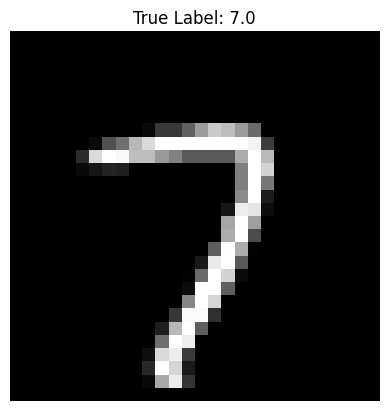

Predicted Label:  7.0


In [150]:

idx = np.where((predictions == 7) & (Y_test == 7))[0]

num = 3

# Reshape the first row into a 28x28 image
first_image = X_test[idx[num]].reshape(28, 28)

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.title(f"True Label: {Y_test[idx[num]]}")
plt.axis('off')
plt.show()

print("Predicted Label: ", predictions[idx[num]])

plt.show()

Now, let's save version 1 of our model (98.78% correct on 10.000 pics)

In [126]:
from joblib import dump

# Save both PCA and SVM to a single file
dump({'pca': pca, 'svm': svm}, 'pca_svm_pipeline.joblib')


['svm_model.joblib']

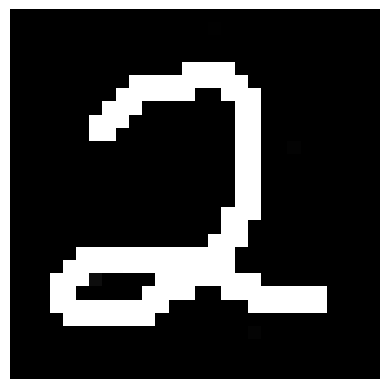

Predict:  [2.]


In [177]:
from PIL import Image

def half_processed_image(image_path):
    image = Image.open(image_path)
    image = image.resize((28, 28))
    image = image.convert('L')  # 'L' mode is 8-bit pixels, grayscale
    image_array = np.array(image)
    input_data = image_array.flatten()

    return input_data

def preprocess_image(image_path, pca):
    # Step 1: Load the image
    image = Image.open(image_path)

    # Step 2: Resize to 28x28 (if not already)
    image = image.resize((28, 28))

    # Step 3: Convert to grayscale
    image = image.convert('L')  # 'L' mode is 8-bit pixels, grayscale

    # Step 4: Invert colors (if needed)
    # Ensure the digit is white (255) and background is black (0)

    image_array = np.array(image) # Scale to range [0, 1]


    # Step 5: Flatten the image into a 1D array
    input_data = image_array.flatten()

    input_data = input_data.reshape(1, -1)

    input_data = pca.transform(input_data)/255.0

    return input_data

# Example usage
image_path = "images/pic1.png"  # Replace with your image path
input_data = preprocess_image(image_path, pca = pca)

# Reshape the first row into a 28x28 image
first_image = half_processed_image("images/pic1.png").reshape(28, 28)

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.show()

print("Predict: ", svc.predict(input_data))

